In [1]:
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import *
import numpy as np
import time

In this file we want to construct a tool in order to get historical data for a list of words on google trends and create an index with this data. <br/>

The Limitations of Google Trend: <br/>
https://towardsdatascience.com/reconstruct-google-trends-daily-data-for-extended-period-75b6ca1d3420:
However, google currently limit the time resolution based on the query’s time frame. For example, query for the last 7 days will have hourly search trends (the so-called real time data), daily data is only provided for query period shorter than 9 months and up to 36 hours before your search (as explained by Google Trends FAQ), weekly data is provided for query between 9 month and 5 years, and any query longer than 5 years will only return monthly data.

Monthly data is a too large frequency for our index, however we need to get historical data for more than 5 years. Therefore, we need to find a way to transform our monthly data into (at least) weekly data.

# Function to excract data for a list of words

In [2]:
def google_trend_data_word(list_word, period_time):

    '''The objective of this function is to exctract the historical data from Google trend for a list of word
    list_word: is the list of words for which we want to have the historical data on google trend
    period_time: the timeframe of our desired data; see https://pypi.org/project/pytrends/ to see the different formats of the
    timeframe
    '''
    #print(list_word)
    #Initialize API for Google Trends, we only look in the US (default)
    pytrends = TrendReq()
    
    #''''''''''''''''''''''''''''''''''''''
    # Get the historical data
    #''''''''''''''''''''''''''''''''''''''
    pytrends.build_payload(list_word, cat=0, timeframe=period_time, geo='US', gprop='')
    #Extract historic data
    word_history = pytrends.interest_over_time()
    #concat word_history pd and collection_word_data pd
    word_history=word_history.drop(labels=['isPartial'],axis='columns')
    
    
    return word_history

In [3]:
def get_daily_data_weekly(list_word, start_date):
    
    '''
    The objective of this function is to download daily data data for every week starting at the start date
    The start date has to be a Sunday and <5 years from now
    '''
    
    end_week_days=[]
    
    #Initialize DataFrame
    collection_word_data=pd.DataFrame()
    
    first_date=start_date.date()
    #now=last day of last week
    now = dt.datetime.today().date() - dt.timedelta(days=dt.datetime.today().date().weekday())-dt.timedelta(days=1)
    end_week_days.append(first_date)
    
    #We are going to exctract daily data for every week from the start date to the first day of the current week
    #While the first date is before the first day of the current week we continue to exctract daily data for words
    while (first_date+dt.timedelta(days=7))<now:
        
        #we add 1 week to the current_date so that we have daily data
        end_first_date=(first_date+dt.timedelta(days=6))
        end_week_days.append(end_first_date+dt.timedelta(days=1))
        
        time_frame_used=str(first_date)+' '+str(end_first_date)

        #get the historic daily data of this week
        temp_df=google_trend_data_word(list_word, time_frame_used)
        #concat DataFrame
        collection_word_data=pd.concat([collection_word_data,temp_df],axis=0)

        #update first date
        first_date=end_first_date+dt.timedelta(days=1)
    
        time.sleep(0.5)
    
    return collection_word_data,end_week_days

In [4]:
def get_weekly_data(list_word, start_date):
    
    '''
    The objective of this function is to download the weekly data for a period of time (must be < 5 years)
    The start date has to be a Sunday and <5 years from now
    '''
    
    now = dt.datetime.today().date() - dt.timedelta(days=dt.datetime.today().date().weekday()-1)
    
    first_date=start_date.date()
    weekly_time_frame=str(first_date)+' '+str(now)

    weekly_data=google_trend_data_word(list_word, weekly_time_frame)
        
    return weekly_data

In [5]:
def get_daily_data_monthly(list_word, start_date):
   
    '''
    The objective of this function is to download daily data data for every month starting at the start date
    The start date has to the first day of a month and >5 years
    '''

    #Initialize DataFrame
    golbal_word_data=pd.DataFrame()
    
    first_date=start_date.date()
    #now=first day of the current month
    now = dt.datetime.today().replace(day=1).date()

    #We are going to exctract daily data for every month from the start date to the first day of the current month
    #While the first date is before the first day of the current month we continue to exctract daily data for words
    while (first_date+relativedelta(months=+1))<now:

        #we add 1 months to the current_date so that we have daily data
        end_first_date=(first_date+relativedelta(months=+1))
        time_frame_used=str(first_date)+' '+str(end_first_date)

        #get the historic daily data of this month
        temp_df=google_trend_data_word(list_word, time_frame_used)

        #concat DataFrame
        golbal_word_data=pd.concat([golbal_word_data,temp_df],axis=0)

        #update first date
        first_date=end_first_date
        
    return golbal_word_data

In [6]:
def get_monthly_data(list_word, start_date):
    
    '''
    The objective of this function is to download the monthly data  for a period of time (must be > 5 years)
    The start date has to be the first day of a month
    '''
    
    now = dt.datetime.today().replace(day=1).date()
    
    #First, get the monthly data
    first_date=start_date.date()
    monthly_time_frame=str(first_date)+' '+str(now)

    monthly_data=google_trend_data_word(list_word, monthly_time_frame)
        
    return monthly_data

# Functions that create daily data index using monthly frequency data

## Method 1

Based on: https://medium.com/@bewerunge.franz/google-trends-how-to-acquire-daily-data-for-broad-time-frames-b6c6dfe200e6

In [7]:
def daily_data_long_time_period_method1(golbal_word_data,monthly_data):
    
    #The method is to multiply the daily data * monthly data associated with the month and divide by 100
    daily_data_np=np.zeros((golbal_word_data.shape[0],golbal_word_data.shape[1]))
    j=0
    for i in range(golbal_word_data.shape[0]):
        #check if year and month are = between the dfs
        if (golbal_word_data.index[i].month==monthly_data.index[j].month) & (golbal_word_data.index[i].year==monthly_data.index[j].year):
        
            daily_data_np[i,:]=golbal_word_data.iloc[i,:]*(monthly_data.iloc[j,:]/100)
         
        else:
            while (golbal_word_data.index[i].month!=monthly_data.index[j].month) or (golbal_word_data.index[i].year!=monthly_data.index[j].year):
                j=j+1
        
            daily_data_np[i,:]=golbal_word_data.iloc[i,:]*(monthly_data.iloc[j,:]/100)
            
    daily_data_df=pd.DataFrame(daily_data_np,columns=golbal_word_data.columns,index=golbal_word_data.index)
    
    return daily_data_df


def method1_daily_data(list_word, start_date):
    '''
    This first method we use daily and monthly data to create a global daily data
    The date has to be the first day of a month on a Datetime format and the start date must be > 5 years from today 
    '''
    
    #First, get the daily data
    golbal_word_data=get_daily_data_monthly(list_word, start_date)
    
    #Then get the monthly data
    monthly_data=get_monthly_data(list_word, start_date)
    
    #Finally, we construct the daily data
    daily_data_df=daily_data_long_time_period_method1(golbal_word_data,monthly_data)
    
    return daily_data_df,monthly_data

In [8]:
list_word=["Debt","Economy"]
start_date=dt.datetime(2015, 1, 1)

### Download daily and monthly data

In [10]:
monthly_daily_data=get_daily_data_monthly(list_word, start_date)

In [11]:
monthly_daily_data.to_csv('monthly_daily_data.csv')

In [12]:
monthly_data=get_monthly_data(list_word, start_date)

In [13]:
monthly_data.to_csv('monthly_data.csv')

### Call Method 1

In [14]:
method1_daily_data=daily_data_long_time_period_method1(monthly_daily_data,monthly_data)

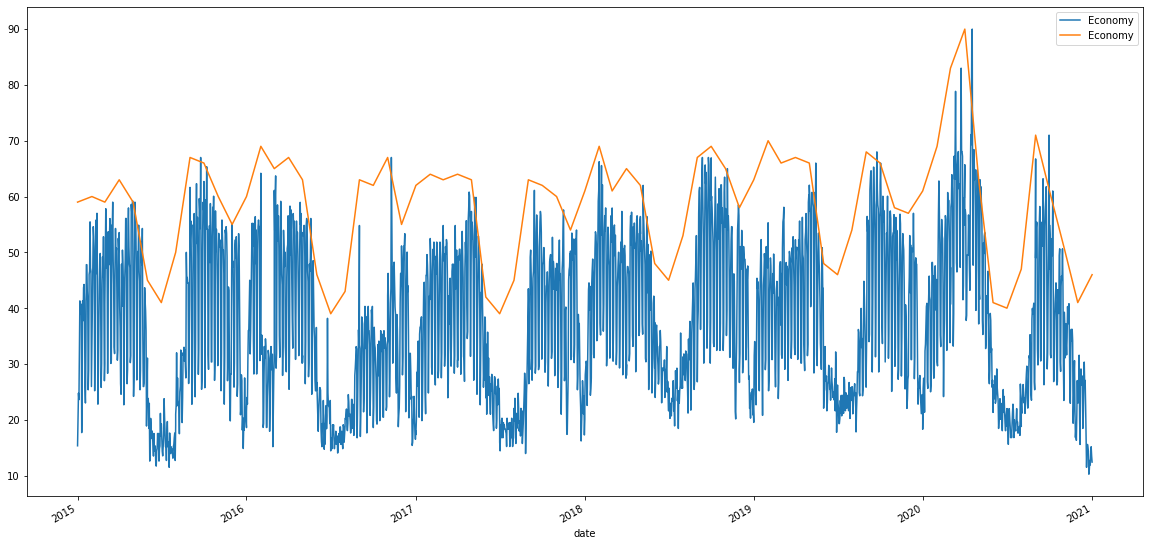

In [16]:
method1_daily_data['Economy'].plot(figsize=(20,10),legend=True)
monthly_data['Economy'].plot(figsize=(20,10),legend=True)
plt.show()

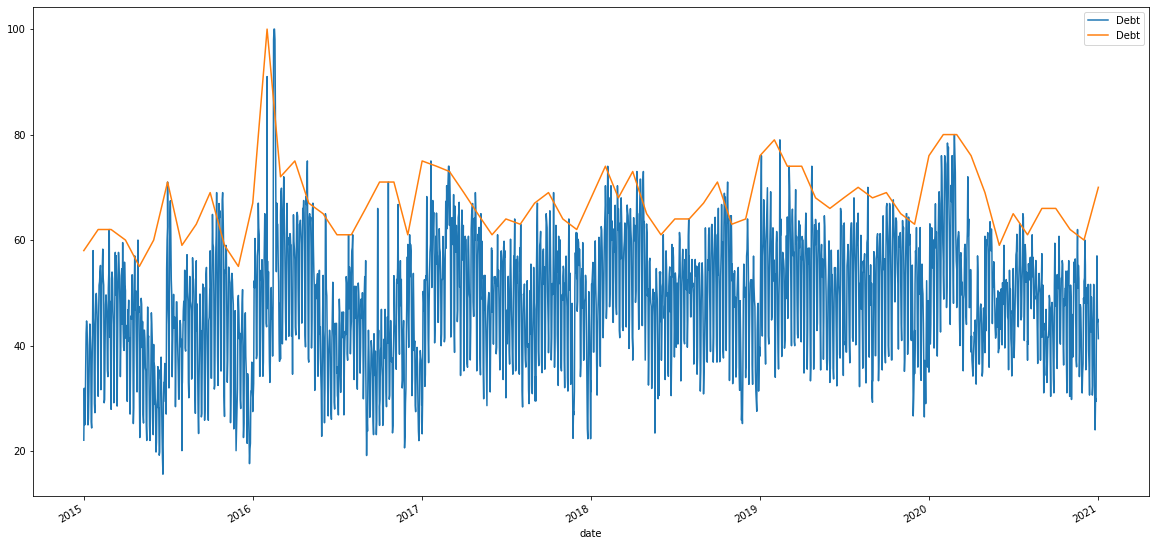

In [17]:
method1_daily_data['Debt'].plot(figsize=(20,10),legend=True)
monthly_data['Debt'].plot(figsize=(20,10),legend=True)
plt.show()

## Method 2

Based on: http://erikjohansson.blogspot.com/2013/04/how-to-get-daily-google-trends-data-for.html

In [21]:
def daily_data_long_time_period_method2(golbal_word_data, monthly_data):
   
    #The method is to multiply the monthly data * the return of the daily data
    daily_data_np=np.zeros((golbal_word_data.shape[0],golbal_word_data.shape[1]))
    j=0
    for i in range(golbal_word_data.shape[0]):
        #we check that the month of the day = month of the monthly database
        if not ((golbal_word_data.index[i].month==monthly_data.index[j].month) & (golbal_word_data.index[i].year==monthly_data.index[j].year)):
            while (golbal_word_data.index[i].month!=monthly_data.index[j].month) or (golbal_word_data.index[i].year!=monthly_data.index[j].year):
                    j=j+1
        #if it is the first day of a month, then this is the monthly value
        if golbal_word_data.index[i].day==1:
            daily_data_np[i,:]=monthly_data.iloc[j,:]
        else:
            daily_data_np[i,:]=daily_data_np[i-1,:]*(1+(golbal_word_data.iloc[i,:]-golbal_word_data.iloc[i-1,:])/(golbal_word_data.iloc[i-1,:]))
        
    daily_data_df=pd.DataFrame(daily_data_np,columns=golbal_word_data.columns,index=golbal_word_data.index)
    
    return daily_data_df

def method2_daily_data(list_word, start_date):
    '''
    The date has to be the first day of a month on a Datetime format and the start date must be > 5 years from today
    For this second method we are going to use the daily return to create the daily index.
    '''
    
    #First, get the daily data
    golbal_word_data=get_daily_data_monthly(list_word, start_date)
    
    #Then get the monthly data
    monthly_data=get_monthly_data(list_word, start_date)
    
    #Finally, we construct the daily data
    daily_data_df=daily_data_long_time_period_method2(golbal_word_data,monthly_data)
    
    return daily_data_df,monthly_data

### Call Method 2

In [22]:
method2_daily_data=daily_data_long_time_period_method2(monthly_daily_data,monthly_data)

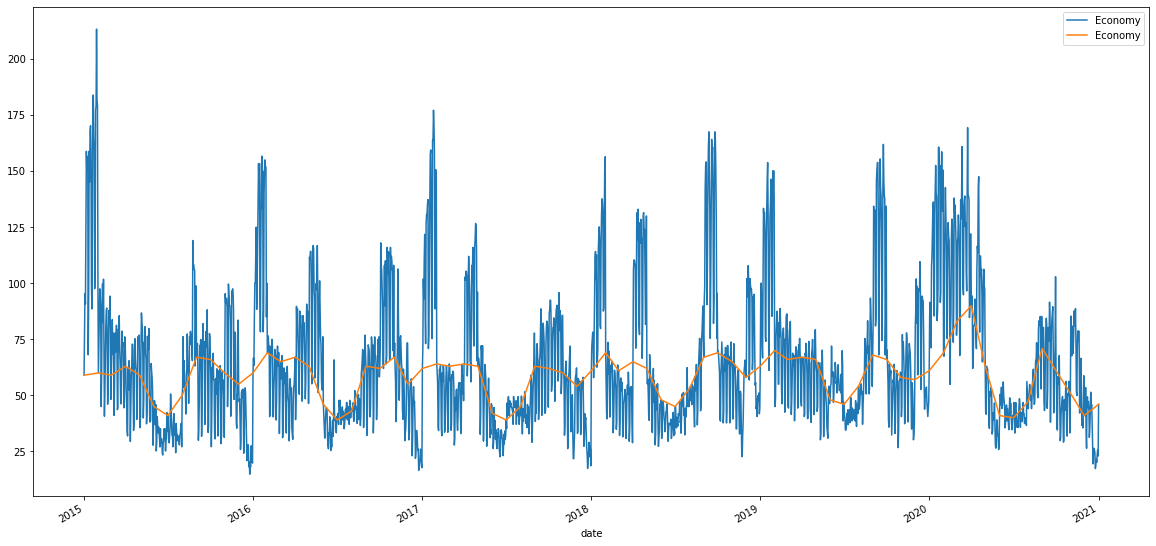

In [23]:
method2_daily_data['Economy'].plot(figsize=(20,10),legend=True)
monthly_data['Economy'].plot(figsize=(20,10),legend=True)
plt.show()

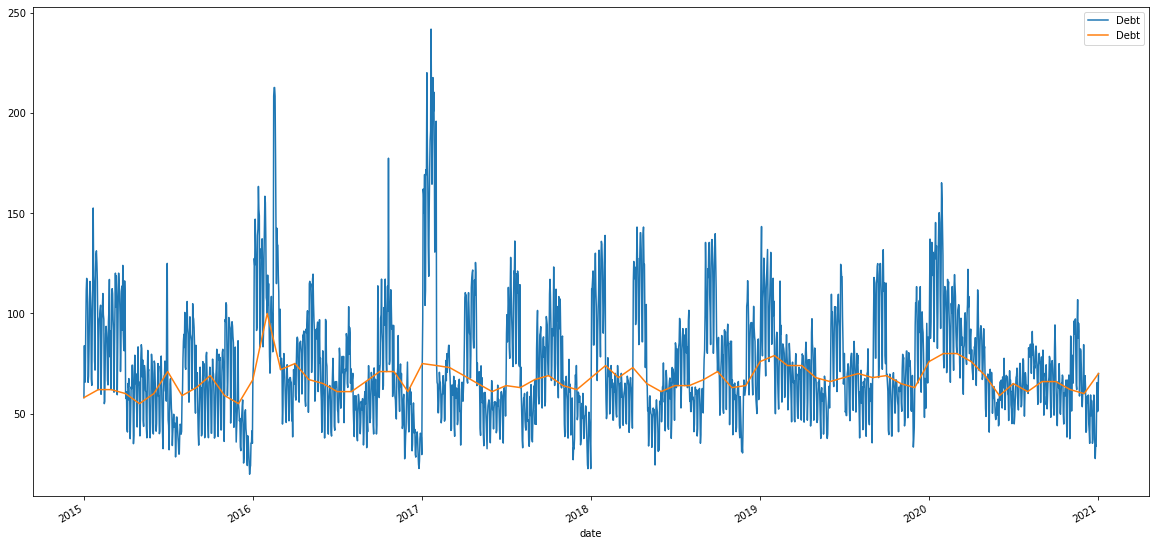

In [24]:
method2_daily_data['Debt'].plot(figsize=(20,10),legend=True)
monthly_data['Debt'].plot(figsize=(20,10),legend=True)
plt.show()

The problem is that we are not capped at 100 anymore.

# Functions using weekly data to get daily data

Time Frame has to be less than 5 years

## Method 3

In [55]:
'''
This third method we use daily and weekly data to create a global daily data
The date has to be the last day of a week (sunday) on a Datetime format and the start date must be < 5 years from today 
'''

def daily_data_weekly_data_method3_global(global_word_data,weekly_data_words,end_week_days):
        
    daily_data_np=np.zeros((global_word_data.shape[0],global_word_data.shape[1]))
    j=0
    
    for i in range(global_word_data.shape[0]):
        #if it is the first day of a week, then this is the weekly value
        if global_word_data.index[i] in end_week_days:
            j=j+1
            daily_data_np[i,:]=global_word_data.iloc[i,:]*(weekly_data_words.iloc[j-1,:]/100)
        else:
            daily_data_np[i,:]=global_word_data.iloc[i,:]*(weekly_data_words.iloc[j-1,:]/100)
            
    daily_data_df=pd.DataFrame(daily_data_np,columns=global_word_data.columns,index=global_word_data.index)
    
    return daily_data_df

def method3_daily_data (list_word, start_date):
    
    collection_word_data,end_week_days=get_daily_data_weekly(list_word, start_date)
    
    weekly_data=get_weekly_data(list_word, start_date)
    
    daily_data_df=daily_data_weekly_data_method3_global(collection_word_data,end_week_days,weekly_data)
    
    return daily_data_df,weekly_data

In [26]:
start_date=dt.datetime(2017, 1, 1)

### Download daily and weekly data

In [32]:
weekly_daily_data,end_week_days=get_daily_data_weekly(list_word, start_date)

In [33]:
weekly_daily_data.to_csv('weekly_daily_data.csv')

In [34]:
weekly_data=get_weekly_data(list_word, start_date)

In [35]:
weekly_data.to_csv('weekly_data.csv')

### Call Method 3

In [56]:
method3_daily_data=daily_data_weekly_data_method3_global(weekly_daily_data,weekly_data,end_week_days)

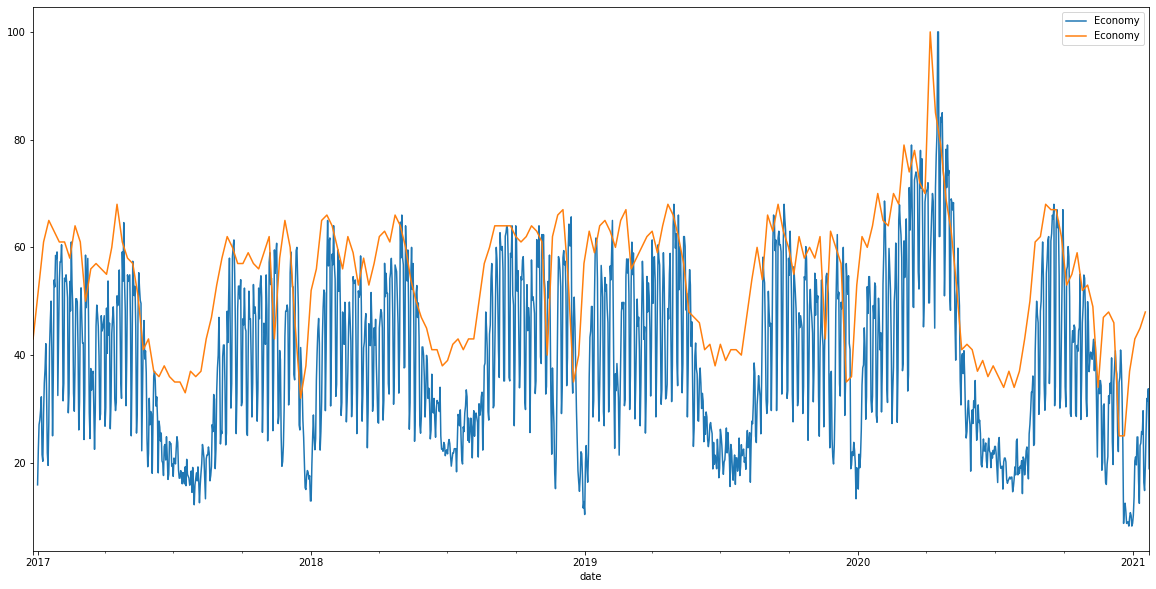

In [39]:
method3_daily_data['Economy'].plot(figsize=(20,10),legend=True)
weekly_data['Economy'].plot(figsize=(20,10),legend=True)
plt.show()

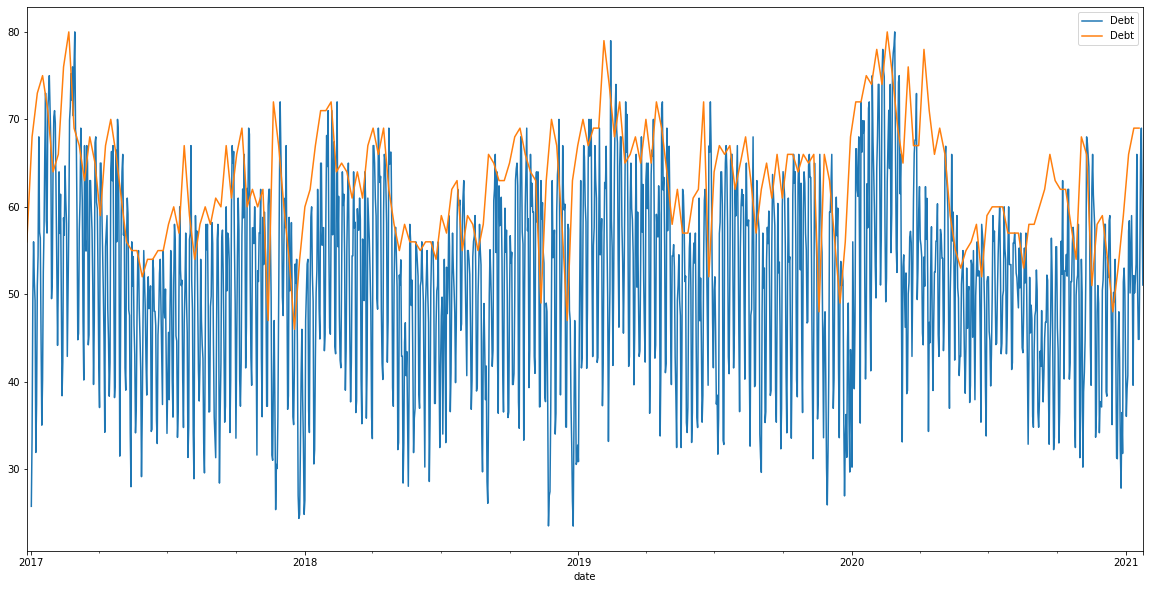

In [40]:
method3_daily_data['Debt'].plot(figsize=(20,10),legend=True)
weekly_data['Debt'].plot(figsize=(20,10),legend=True)
plt.show()

## Method 4

In [59]:
def daily_data_weekly_data_method4_global(global_word_data,weekly_data,end_week_days):
        
    daily_data_np=np.zeros((global_word_data.shape[0],global_word_data.shape[1]))
    j=0
    for i in range(global_word_data.shape[0]):
        #if it is the first day of a week, then this is the weekly value
        if global_word_data.index[i] in end_week_days:
            j=j+1
            
            daily_data_np[i,:]=weekly_data.iloc[j-1,:]
        else:
            daily_data_np[i,:]=daily_data_np[i-1,:]*(1+(global_word_data.iloc[i,:]-global_word_data.iloc[i-1,:])/(global_word_data.iloc[i-1,:]))
            
    daily_data_df=pd.DataFrame(daily_data_np,columns=global_word_data.columns,index=global_word_data.index)
    
    return daily_data_df

def method4_daily_data (list_word, start_date):
    
    collection_word_data,end_week_days=get_daily_data_weekly(list_word, start_date)
    
    weekly_data=get_weekly_data(list_word, start_date)
    
    daily_data_df=daily_data_weekly_data_method4_global(collection_word_data,end_week_days,weekly_data)
    
    return daily_data_df,weekly_data

### Call Method 4

In [60]:
method4_daily_data=daily_data_weekly_data_method4_global(weekly_daily_data,weekly_data,end_week_days)

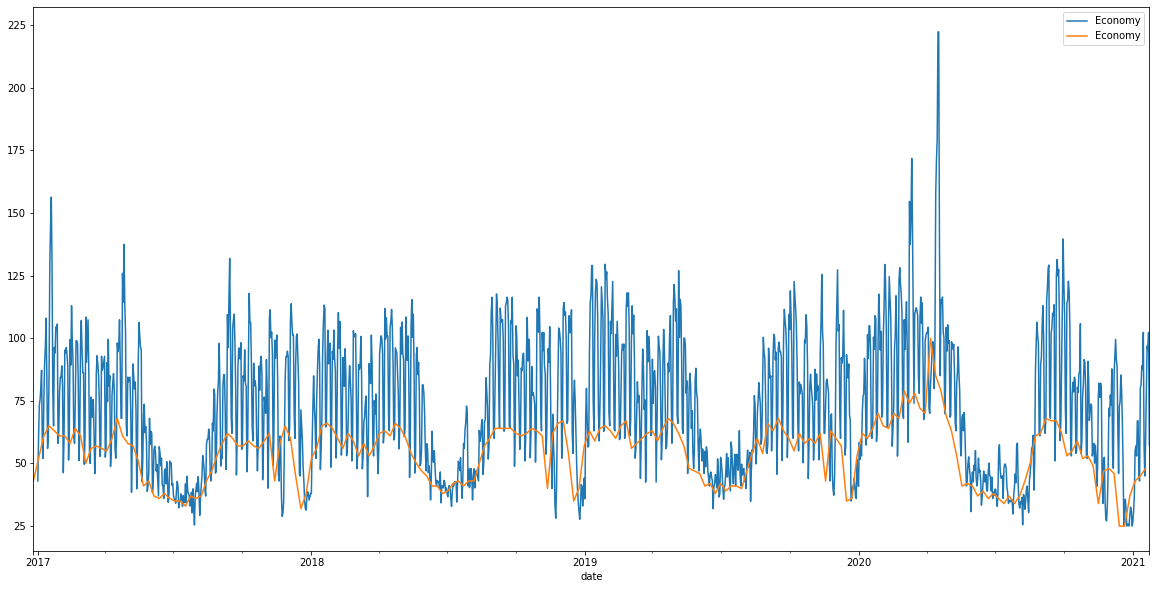

In [61]:
method4_daily_data['Economy'].plot(figsize=(20,10),legend=True)
weekly_data['Economy'].plot(figsize=(20,10),legend=True)
plt.show()

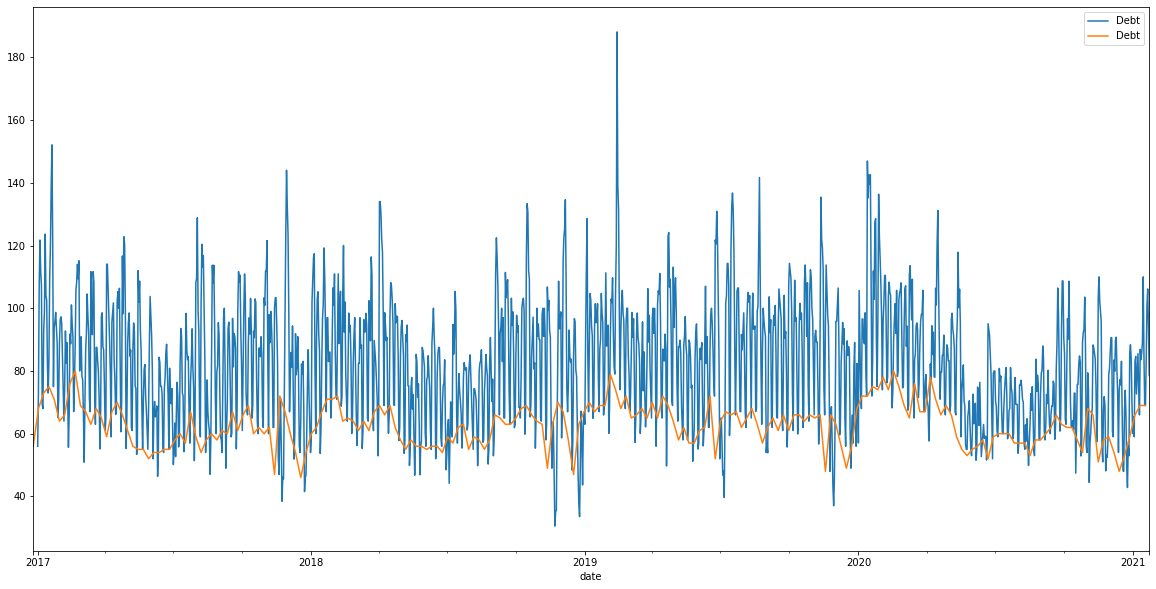

In [62]:
method4_daily_data['Debt'].plot(figsize=(20,10),legend=True)
weekly_data['Debt'].plot(figsize=(20,10),legend=True)
plt.show()

# Creation GTU Index

## Method 1: Simple Weighted Index

In [63]:
def weighted_index_construction(data,weight):
    weighted_data=data.multiply(weight,axis=1)
    GTU_INDEX=weighted_data.sum(axis=1)
    return GTU_INDEX

In [67]:
Test_index=weighted_index_construction(method3_daily_data,[0.5,0.5])

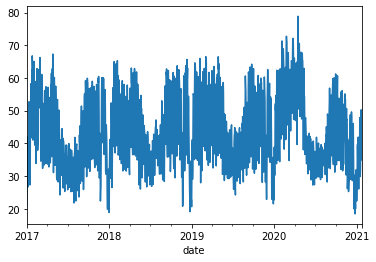

In [68]:
Test_index.plot()

## Method 2: Google it Up method using weekly data

In [155]:
def google_it_up_method(list_words,Benchmark_word,start_date):
    
    #temp variable for list_word
    temp_list_words=list_words
    
    #Initialization of the DF that will stock all the weekly search
    global_dataframe=pd.DataFrame()
    
    list_search=[Benchmark_word]
    #The Benchmark_word won't move from that list
    
    #We have to compute the FI*_y then we have to do the first round manually
    if len(temp_list_words)>=4:
        list_search.extend(temp_list_words[0:4])
    else:
        list_search.extend(temp_list_words[0:len(temp_list_words)])
    
    #print(list_search)
    
    google_trend_temp_list=get_weekly_data(list_search, start_date)
    
    FI_y_star=google_trend_temp_list[Benchmark_word]
    
    global_dataframe=pd.concat([global_dataframe,google_trend_temp_list.iloc[:,1:]],axis=1)
    
    del list_search[1:]
    del temp_list_words[0:4]
        
    #''''''''''
    #Then, we can begin the loop
    #''''''''''
    
    #while the list of words is not empty we continue
    while temp_list_words:
        #if the list has more or = to 4 words then we add 4 words else we add the rest of the words
        if len(temp_list_words)>=4:
            list_search.extend(temp_list_words[0:4])
        else:
            list_search.extend(temp_list_words[0:len(temp_list_words)])
            
        #print(list_search)
        
        google_trend_temp_list=get_weekly_data(list_search, start_date)
        #print(google_trend_temp_list)
        FI_google_trend_temp=FI_y_star.div(google_trend_temp_list[Benchmark_word])
        
        google_trend_temp_list=google_trend_temp_list.mul(FI_google_trend_temp,axis=0)
        #print(google_trend_temp_list)
        
        global_dataframe=pd.concat([global_dataframe,google_trend_temp_list.iloc[:,1:]],axis=1)
        
        del list_search[1:]
        del temp_list_words[0:4]
        
        #print(global_dataframe)
        #print(list_search)
        #print(temp_list_words)
    
    global_dataframe=pd.concat([global_dataframe,FI_y_star],axis=1)
    
    GTU_INDEX=global_dataframe.sum(axis=1)
    
    return GTU_INDEX

In [193]:
list_words=['Economy','Default','Crisis','Inflation','Recession','Monetary policy','Food Price','Bankruptcy']
Benchmark_word='Debt'
start_date=dt.datetime(2016, 2, 7)

In [194]:
TEST_GTU_INDEX=google_it_up_method(list_words,Benchmark_word,start_date)

In [195]:
TEMP_GTU_Index=TEST_GTU_INDEX

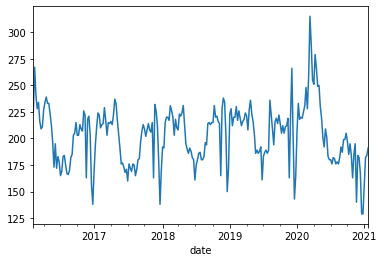

In [196]:
TEMP_GTU_Index.plot()

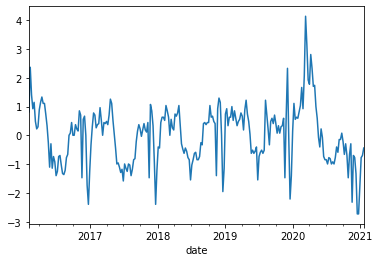

In [197]:
TEMP_GTU_Index=(TEMP_GTU_Index-TEMP_GTU_Index.mean())/TEMP_GTU_Index.std()
TEMP_GTU_Index.plot()

In [198]:
TEMP_GTU_Index=TEMP_GTU_Index*30
print(TEMP_GTU_Index.std())

30.000000000000004


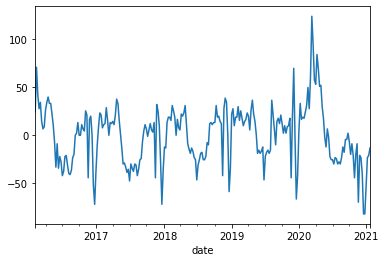

In [199]:
TEMP_GTU_Index.plot()

In [200]:
TEMP_GTU_Index=TEMP_GTU_Index+100

In [201]:
TEMP_GTU_Index.mean()

99.99999999999997

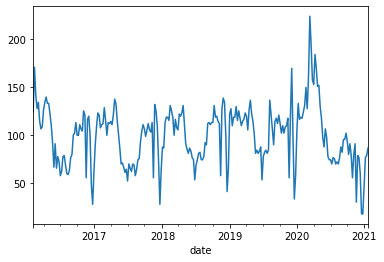

In [202]:
TEMP_GTU_Index.plot()